In [2]:
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline 
plt.rcParams["figure.figsize"] = (3,3)
from mpl_toolkits.mplot3d import Axes3D
from scipy.integrate import solve_ivp

Bifurcations de populations de neurones
======================

Le but de ce projet est de simuler l'évolution de l'activité moyenne de groupes de neurones en intéraction, à l'aide d'un modèle simplifié de *Wilson-Cowan*. En notant $x=(x_1,...,x_i,..., x_n)\in \mathbb{R}^n$ le vecteur contenant l'activité moyenne de chacun des $n$ groupes de neurones, ce modèle s'écrit (en grandeurs normalisées)
$$
\tau \dot x = - x + S(Wx + d^{\rm ext})
$$
où $\tau$ est une constante de temps, $W \in \mathbb{R}^{n\times n}$ est une matrice décrivant les intéractions entre groupes de neurones, $d^{\rm ext}\in \mathbb{R}^n$ peut contenir des stimulis/perturbations extérieurs impactant chaque groupe, et $S: \mathbb{R}^n \to \mathbb{R}^n$ est de la forme
$$
S({\rm x}_1,...,{\rm x}_i ,...,{\rm x}_n) = (s_1({\rm x}_1),...,s_i({\rm x}_i),...,s_n({\rm x}_n))
$$
où $s_i:\mathbb{R}\to \mathbb{R}$ sont des fonctions dites d'*activation*.

Ces fonctions d'activation permettent de modéliser le fait que l'activité environnante d'un groupe de neurone doit atteindre un certain seuil avant d'exciter ce groupe. Des choix courants de fonctions d'activation sont la tangente hyperbolique ou des sigmoides de la forme
$$
s({\rm x}) = \frac{1}{1+ e^{-a(x-\theta)}}-\frac{1}{1+e^{a\theta}}
$$
où $\theta$ représente le seuil d'activation et $a$ sa pente, comme illustré ci-dessous. 

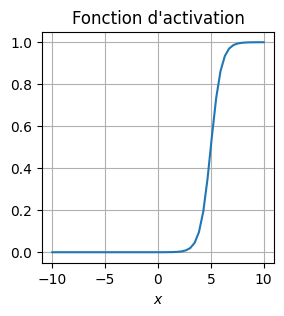

In [3]:
def sigmoid(x):
    a = 2.0   # la pente au niveau du seuil est a/4
    theta = 5.0  # seuil
    return 1/(1+np.exp(-a*(x-theta)))-1/(1+np.exp(a*theta))

x = np.linspace(-10,10)
plt.figure()
plt.plot(x,sigmoid(x))
plt.grid(True)
plt.xlabel('$x$')
plt.title("Fonction d'activation")
plt.show()

Notons que si l'on réécrit l'équation différentielle composante par composante, on trouve que la dynamique de chaque groupe de neurone s'écrit
$$
\tau \dot x_i = -x_i + s_i\left(\sum_{j=1}^n w_{ij}x_j + d_{i}^{\rm ext}\right)
$$

**Question 1** Justifier que si les fonctions d'activation $s_i:\mathbb{R}\to \mathbb{R}$ sont bornées (minorées et majorées) alors toutes les solutions maximales $t\mapsto x(t)$ sont définies sur $\mathbb{R}$ et sont bornées (en temps positif). Relier la borne de $t\mapsto x_i(t)$ à la borne de $s_i$ pour chaque $i$. 


**Réponse question 1**

On utilise le théorème sur le critère d'existence globale. On munit $\mathbb{R}^n$ de la norme canonique, que l'on note $\lvert\lvert . \lvert\lvert$. (On travaille en dimension finie, donc il y a équivalence des normes)

Si on pose : $f : \mathbb{R} \times \mathbb{R}^n \to \mathbb{R}^n$ telle que $ f(t,x) = - x + S(Wx + d^{\rm ext})$, on a :
$$
\forall x \in \mathbb{R}, \lvert\lvert \tau f(x) \lvert\lvert = \lvert\lvert - x + S(Wx + c) \lvert\lvert
$$
($f$ ne dépend pas du temps donc on note $f(x)$ pour $f(t,x)$)

Donc, par inégalité triangulaire :
$$
\forall x \in \mathbb{R}, \lvert\lvert \tau f(x) \lvert\lvert \leq \lvert\lvert x \lvert\lvert + \lvert\lvert S(Wx + d^{\rm ext}) \lvert\lvert
$$

Or toutes les fonctions d'activation $s_i$ sont bornées, donc il existe $M \in \mathbb{R}$ tel que :
$$
\forall x \in \mathbb{R}, \lvert\lvert S(Wx + d^{\rm ext}) \lvert\lvert \leq M
$$

Ainsi :
$$
\forall x \in \mathbb{R}, \lvert\lvert f(x) \lvert\lvert \leq \frac{1}{\lvert \tau \lvert} \lvert\lvert x \lvert\lvert + \frac{M}{\lvert \tau \lvert}
$$
i.e. f a une croissance au plus affine, donc toute solution maximale est définie sur $\mathbb{R}$ tout entier.

Montrons maintenant que toute solution maximale est bornée.
Comme $f$ est continue et on travaille sur des ouverts, d'après le théorème sur le domaine maximal d'existence: $(t,x)$ tend vers la frontière de $\mathbb{R} \times X$ ou diverge lorsque $t \to \infty$. (où $X$ est l'ouvert de $\mathbb{R}^n$ dans lequel sont les valeurs possibles de $x(t)$.)

Par l'absurde, supposons qu'il existe $i$ tel que $x_i$ est non bornée.

Alors $x_i \to \infty$ pour $t \to \infty$. Or dans l'équation différentielle, toutes les $s_i$ étant bornées, $\dot x_i \sim -x_i$ pour $t \to \infty$. Donc $x_i$ est une fonction infiniment décroissante qui tend vers $+\infty$. Absurde.

Ainsi $x_i$ est bornée.

Ceci est vrai pour tout $i$, donc on peut affimer que pour tout $i$, $\dot x_i$ est aussi bornée, d'après l'équation différentielle. Donc on peut relier la borne de $x_i$ à celle de $s_i$ via celle de $\dot x_i$ comme suit :

$$
M_{x_i} \leq M_{\dot x_i} + M_{s_i}
$$
où $M_i$ est la borne de l'élément $i$.


Pour simplifier, on étudie ce système en dimension 2, c'est-à-dire avec deux groupes de neurones: le premier ayant un effet *excitant* et le deuxième *inhibant*. On traduit cela par la matrice d'interconnection suivante.

In [4]:
W = np.array([[5.0, -4.0], [8.0, -1.0]])
print(W)

[[ 5. -4.]
 [ 8. -1.]]


On fixe aussi $s_1=s_2$ données par la sigmoide ci-dessus, ainsi que $\tau=1$ puisque faire varier $\tau$ ne change que l'échelle de temps. On va essayer d'étudier et exploiter la grande richesse de comportements asymptotiques possibles pour différentes valeurs de $d^{\rm ext}$.

Points d'équilibre
================

On commence par considérer $d^{\rm ext}$ constant. Ses composantes $d_1^{\rm ext}$ et $d_2^{\rm ext}$ peuvent donc être vus comme des paramètres du système. Les points d'équilibre $x^{\rm eq}\in \mathbb{R}^n$ se caractérisent alors par l'équation
$$
x^{\rm eq} = S(W x^{\rm eq} + d^{\rm ext})
$$
La fonction suivante trace les points $(x_1,x_2)$ tels que $-x_1+s(w_{11}x_1+w_{12}x_2+d_1^{\rm ext})=0$ (en rouge) et $-x_2+s(w_{21}x_1+w_{22}x_2+d_2^{\rm ext})=0$ (en vert) pour des valeurs de $d^{\rm ext}$ à choisir.

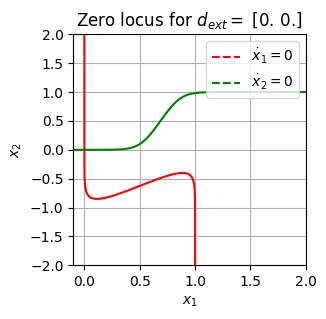

In [5]:
def plot_zero_locus(d_ext):
    grid_x1 = np.linspace(-0.1,2.0,100)
    grid_x2 = np.linspace(-2.0,2.0,100)
    X1, X2 = np.meshgrid(grid_x1,grid_x2)

    X1dot = -X1 + sigmoid(W[0,0]*X1 + W[0,1]*X2 + d_ext[0])
    X2dot = -X2 + sigmoid(W[1,0]*X1 + W[1,1]*X2 + d_ext[1])

    plt.figure()
    C1 = plt.contour(X1, X2, X1dot, 0, colors = 'red')
    C2 = plt.contour(X1, X2, X2dot, 0, colors = 'green')
    h1,_ = C1.legend_elements()
    h2,_ = C2.legend_elements()
    plt.grid(True)
    plt.xlabel('$x_1$')
    plt.ylabel('$x_2$')
    plt.legend([h1[0],h2[0]],['$\dot x_1 = 0$','$\dot x_2 = 0$'])
    plt.title("Zero locus for $d_{ext} =$ "+ str(d_ext))
    plt.show()
    return


d_ext = np.array([0.0,0.0])  # A CHOISIR
plot_zero_locus(d_ext)

**Question 2** Identifier le point d'équilibre du système pour $d^{\rm ext}=0$ et étudier sa stabilité. 


**Réponse question 2**


Le point d'équilibre du système pour $d^{\rm ext}=0$ est celui tel que $ \dot x_1 = 0 $ et $ \dot x_2 = 0$.
On cherche donc sur le graphique le point appartenant à la fois à la courbe rouge et la courbe verte. Il n'y en a qu'un seul : **le point $(0,0)$**.

Pour savoir s'il est en équilibre stable, on calcule la jacobienne de la fonction $f$ telle que $ \dot x =  f(x,t)$ au point $(0,0)$. On regarde ensuite ses valeurs propres. Si ses valeurs propres sont toutes à parties réelles strictement négatives, alors la position d'équilibre est stable.
Le code ci-dessous nous donne que c'est bien le cas.
**La position d'équilibre est donc stable.**

In [6]:
a = 2.0   # la pente au niveau du seuil est a/4
theta = 5.0  # seuil

jacobienne_f = np.zeros((2,2))
jacobienne_f[0,0] = -1 + (W[0][0]*a*np.exp(-a*(d_ext[0])-theta))/((1+np.exp(-a*(d_ext[0])-theta))**2)
jacobienne_f[0,1] = (W[0][1]*a*np.exp(-a*(d_ext[0])-theta))/((1+np.exp(-a*(d_ext[0])-theta))**2)
jacobienne_f[1,0] = (W[1][0]*a*np.exp(-a*(d_ext[1])-theta))/((1+np.exp(-a*(d_ext[1])-theta))**2)
jacobienne_f[1,1] = -1 + (W[1][1]*a*np.exp(-a*(d_ext[1])-theta))/((1+np.exp(-a*(d_ext[1])-theta))**2)

np.linalg.eigvals(jacobienne_f)

array([-0.97340777+0.06376592j, -0.97340777-0.06376592j])

**Question 3** Tester d'autres valeurs de $d^{\rm ext}$. Par exemple, fixer $d^{\rm ext}_2=4$, et faire varier $d^{\rm ext}_1$ entre 3 et 8. Qu'observe-t-on sur le nombre de points d'équilibre ? Pour $d^{\rm ext}=(6,4)$, on trace ci-dessous le portrait de phase. Retrouver graphiquement les points d'équilibre et intuiter leur stabilité. Quels sont les seuls comportements asymptotiques possibles des solutions pour cette valeur constante de $d^{\rm ext}$ ?

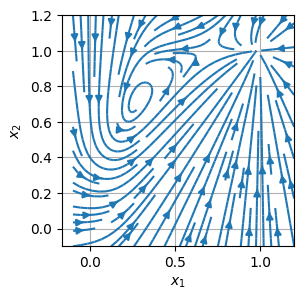

In [7]:
d_ext = np.array([6.0,4.0])  

grid_x1 = np.linspace(-0.1,1.2,70)
grid_x2 = np.linspace(-0.1,1.2,70)
X1, X2 = np.meshgrid(grid_x1,grid_x2)

X1dot = -X1 + sigmoid(W[0,0]*X1 + W[0,1]*X2 + d_ext[0])
X2dot = -X2 + sigmoid(W[1,0]*X1 + W[1,1]*X2 + d_ext[1])

plt.figure()
plt.streamplot(grid_x1, grid_x2, X1dot, X2dot)
plt.grid(True)
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.show()

**Réponse question 3**

Pour une variation de $d^{\rm ext}_1$ d'un pas entier (cf.code dans la cellule ci-dessous), trois points d'équilibre apparaissent pour $d^{\rm ext}=[6,4]$. On retrouve graphiquement sur le portrait de phase qu'il s'agit environ des points : $(0.3,0.7)$ (localement asymptotiquement stable) ; $(0.7,1.0)$ (instable) et $(0.95,1.0)$ (localement asymptotiquement stable). En effet, les flèches convergent vers les deux poins stables alors qu'elles divergent autour du point instable.

Les seuls comportements asymptotiques possibles des solutions pour cette valeur $d^{\rm ext}=[6,4]$ sont la convergence vers l'un de ces trois points d'équilibre, comme on peut le constater sur le portrait de phase (y compris en changeant l'échelle pour voir plus globalement le comportement des solutions).

Il n'y a qu'un point d'équilibre dans les autres cas.

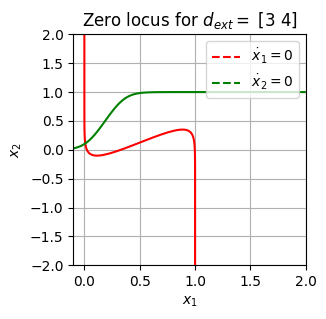

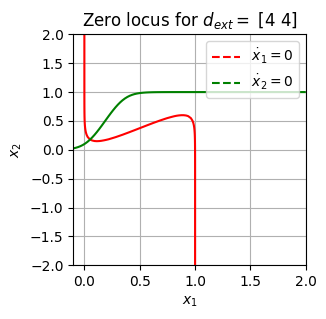

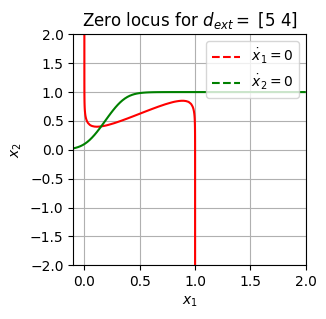

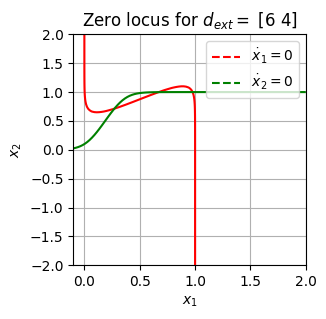

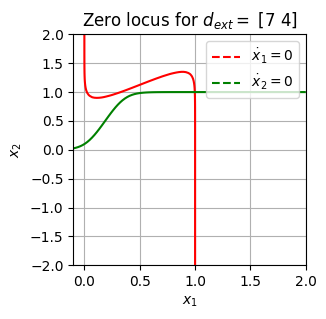

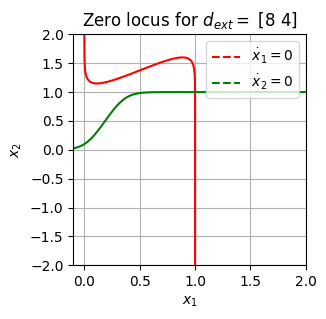

In [8]:
for i in range(3,9):
    plot_zero_locus(np.array([i,4]))

Lorsque le nombre et la nature (stabilité) des points d'équilibre changent brusquement avec des modifications de paramètres, on parle de *bifurcation*. De tels phénomènes permettent généralement de produire des comportements asymptotiques extrêmement riches et variés, simplement en faisant varier ces paramètres. Nous en étudions plusieurs exemples dans la suite.

Simulation des trajectoires
================

**Question 4** Compléter la fonction ``solve_euler_explicit`` ci-dessous prenant en entrée une fonction $f: \mathbb{R}\times\mathbb{R}^n \to \mathbb{R}^n$ quelconque, une condition initiale $x_0$, un pas de temps $dt$, les temps initiaux et finaux, et renvoyant e vecteur des temps $t^j$ et de la solution $x^j$ du schéma d'Euler explicite appliqué à $\dot{x}=f(t,x)$.

In [9]:
def solve_euler_explicit(f, x0, dt, t0, tf):
    n = int((tf-t0)/dt)
    e = [0 for i in range(2*n)]
    e[0], e[n] = t0, x0
    for i in range(1,n):
        e[i] = e[i-1]+ dt
        e [n+i] = e[n+i-1] + dt*f(e[i-1], e[n+i-1])
    return e[:n],e[n:] #permet de renvoyer le bon format pour la question suivante

**Question 5** Expliquer (sans le faire) comment on pourrait trouver numériquement l'ordre de convergence de ce schéma.


**Réponse question 5**

L'ordre de convergence est le plus petit entier p tel qu'il existe une constante $C$ telle que : $$\max\limits_{1 \le j \le J} \lvert \lvert x^j - x(t_j) \lvert \lvert \ \le \ C(dt)^p $$ où $J = \frac{t_f - t_0}{dt}$, et $x$ la solution exacte de l'équation différentielle.
Ici, on ne connait pas $x$. On peut essayer de l'approximer en utilisant une méthode d'Euler explicite avec un pas de temps bien plus élevé, ou en résolvant l'équation différentielle à l'aide d'autres méthodes plus précises. Par exemple, on peut utiliser la méthode scipy.integrate.odeint.
On aura alors une solution plus précise, qu'on pourra comparer avec la solution issue du solveur. 

Pour trouver ensuite l'ordre de convergence du schéma, on remarque que, la fonction logarithme népérien étant croissante, on cherche en fait p et C tels que : $$ln(\max\limits_{1 \le j \le J} \lvert \lvert x^j - x(t_j) \lvert \lvert) \ \le \ p*ln(dt) + ln(C) $$
Il suffit donc de tracer sur une échelle logaritmique du temps $ln(\max\limits_{1 \le j \le J} \lvert \lvert x^j - x(t_j) \lvert \lvert)$ pour différents pas de temps, et de trouver le coefficient directeur de la fonction affine $g$ vérifiant : 
$$\forall dt \in \mathbb{R}, \ ln(\max\limits_{1 \le j \le J} \lvert \lvert x^j - x(t_j) \lvert \lvert) \ \le \ g(ln(dt)) $$
et pour toute fonction affine $f$ vérifiant cette même condition,
$$\forall dt \in \mathbb{R}, \ g(ln(dt)) \le f(ln(dt)) $$

On aura plus qu'à prendre la partie entière du coefficient directeur de $g$ et y ajouter 1 : c'est l'entier p.

Celui-ci peut être obtenu via une régression quantile de quantile 1 (via la librairie ``statsmodel``), qui permet de faire un régression linéaire qui se situe au-dessus de tous les points $ln(\max\limits_{1 \le j \le J} \lvert \lvert x^j - x(t_j) \lvert \lvert)$ en fontion de $ln(dt)$.



**Question 6** On utilise maintenant ``solve_euler_explicit`` pour simuler des trajectoires de neurones lorsque $d^{\rm ext}$ est constant. En vous aidant du portrait de phase de la question 3, illustrer les comportements asymptotiques possibles des solutions pour $d^{\rm ext}=(6,4)$, en choisissant différentes conditions initiales. Lequel ne peut-on pas illustrer numériquement ?

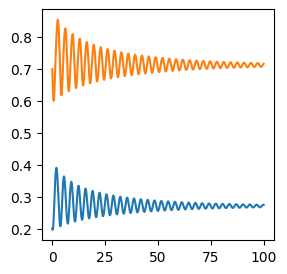

Point éventuel de convergence:  [0.27456511 0.71622753]


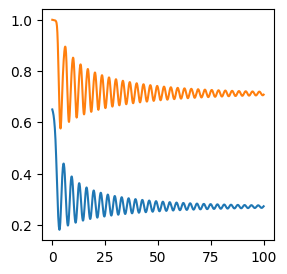

Point éventuel de convergence:  [0.2721942  0.70781898]


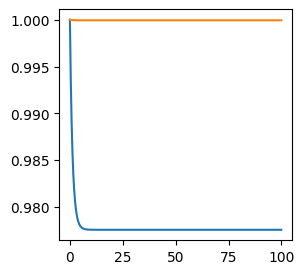

Point éventuel de convergence:  [0.97755292 0.9999458 ]


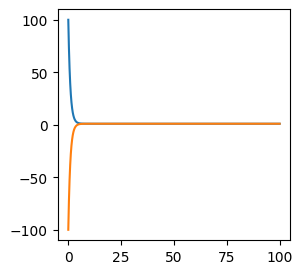

Point éventuel de convergence:  [0.97755292 0.9999458 ]


In [10]:
def f_d_ext_constant(t,x):
    d_ext = np.array([6.0,4.0])
    return -x + sigmoid(np.dot(W,x)+d_ext)

dt = 0.1
t0, tf = 0.0, 100.0
condition_ini=[[0.2,0.7],[0.65,1],[1.0,1.0],[100.0,-100.0]]

for xini in condition_ini :
    x0 = np.array(xini) # A COMPLETER
    time, x = solve_euler_explicit(f_d_ext_constant, x0, dt, t0, tf)
    plt.plot(time,x)
    plt.show()
    print("Point éventuel de convergence: ",x[-1])

**Réponse question 6**

On teste pour différentes valeurs de $x_0$ identifiées sur le portrait de phase de la question 3 comme étant non loin des points d'équilibre : $(0.2,0.7),(0.65,1.0),(1.0,1.0)$, et pour une valeur éloignée $(100.0,-100.0)$.

Comme on l'avait identifié à la question 3, le premier et le troisième point d'équilibre sont des points localement asymptotiquement stables, y compris dans la méthode explicite d'Euler.

En revanche, le comportement du point d'équilibre qu'on avait identifié vers $(0.7,1.0)$ (qui est instable) ne peut pas être illustré numériquement, car le moindre écart à ce point d'équilibre fait qu'il n'en est plus un, et les approximations faites dans les calculs de la méthode d'Euler explipcite suffisent à s'écarter du point d'équilibre.

**Question 7** On fixe maintenant $d_2^{\rm ext}=8$ et on fait varier $d_1^{\rm ext}$ lentement de 4 à 8, puis de 8 à 4. En utilisant ``plot_zero_locus``, justifier le comportement de la solution obtenue. Tracer la solution en fonction de $d_1^{\rm ext}$, comment appelle-t-on ce phénomène ? Justifier que l'on parle de *mémoire courte*.

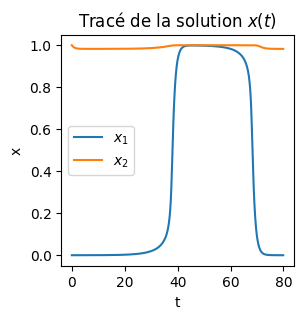

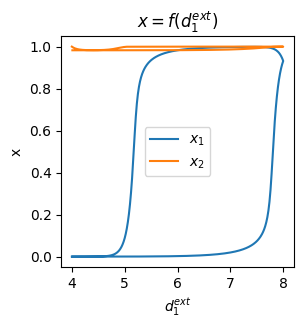

In [21]:
def d_ext_varying(t):
    d1_ext = (0.1*t+4)*(t<40)+(8-0.1*(t-40))*(t>=40)
    d2_ext = 8.0*np.ones(np.shape(t))
    return np.array([d1_ext,d2_ext])

def f_d_ext_varying(t,x):
    return -x + sigmoid(np.dot(W,x)+d_ext_varying(t))

x0 = np.array([0.0,1.0])
dt = 0.1
t0, tf = 0.0, 80.0
time, x = solve_euler_explicit(f_d_ext_varying, x0, dt, t0, tf)

def d1(t):
    return (0.1*t+4)*(t<40)+(8-0.1*(t-40))*(t>=40)

time=np.array(time)

plt.plot(time,x)
plt.xlabel("t")
plt.ylabel("x")
plt.title("Tracé de la solution $x(t)$")
plt.legend(["$x_1$", "$x_2$"])
plt.show()

plt.plot(d1(time),x)
plt.xlabel("$d_1^{ext}$")
plt.ylabel("x")
plt.title("$x=f(d_1^{ext})$")
plt.legend(["$x_1$", "$x_2$"])
plt.show()

#### **Réponse question 7**

On trace d'abord la solution obtenue : on observe des variations brutales de $x_1$. Il s'agit des bifurcations auxquelles nous nous intéressons, ce que l'on vérifie avec l'aide de ``plot_zero_locus`` (*cf.* code ci-dessous) : ces points de rupture de $x$ sont bien dus à un changement brutal du nombre de points d'équilibre, de 3 à 1 seul point d'équilibre.

Le tracé de $x$ en fonction de $d_1^{ext}$ fait apparaître un cycle d'hystérésis pour $x_1$. On parle de *mémoire courte* parce qu'on a été obligé de faire varier $d_1^{ext}$ très lentement pour observer ce phénomène.

t = 30


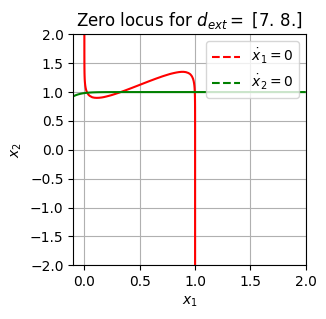

t = 31


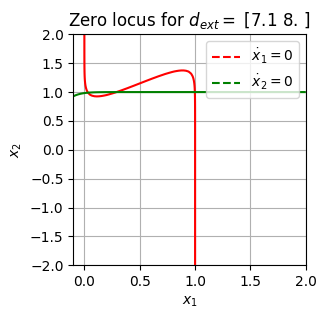

t = 32


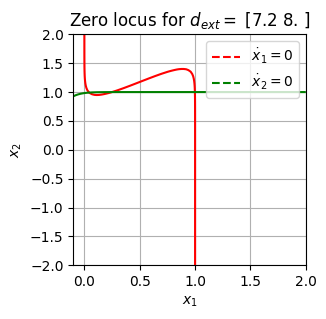

t = 33


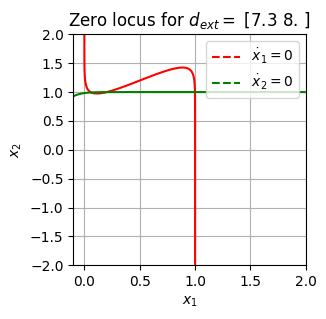

t = 34


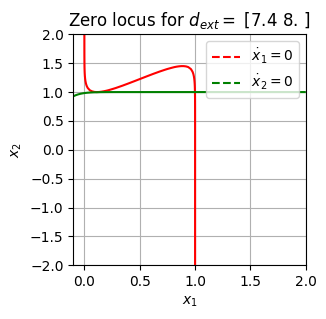

t = 35


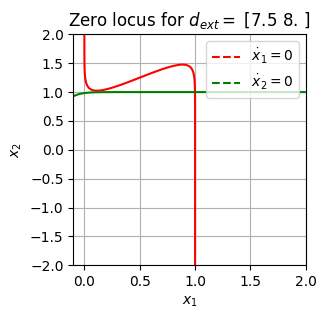

t = 36


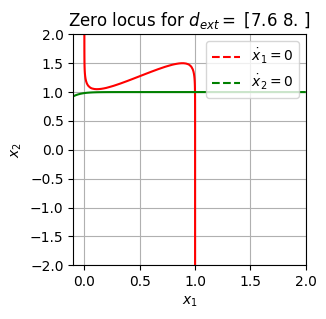

t = 60


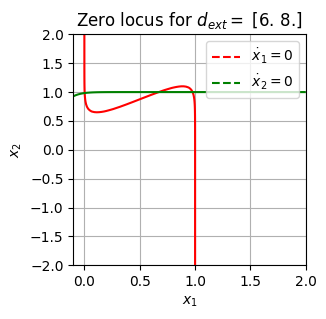

t = 61


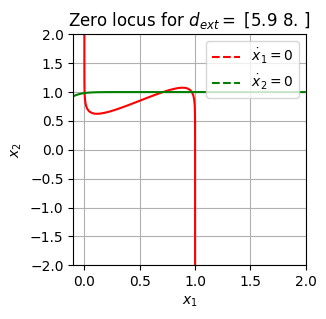

t = 62


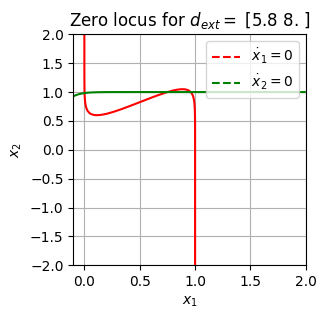

t = 63


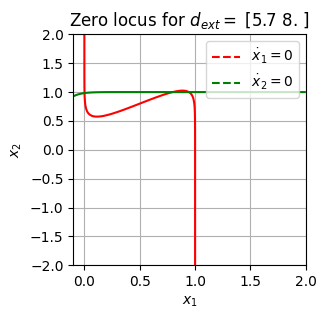

t = 64


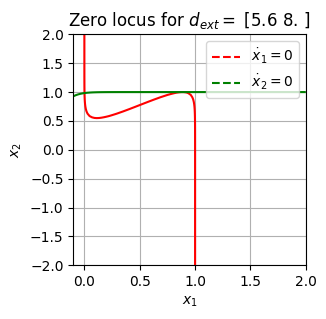

In [17]:
for t in range (30,37) :
    print ("t =",t)
    plot_zero_locus(d_ext_varying(t))

for t in range (60,65) :
    print ("t =",t)
    plot_zero_locus(d_ext_varying(t))

Bendixon et cycle limite
============================

On cherche maintenant à faire apparaître un cycle limite oscillatoire. On s'appuie pour cela sur le théorème de *Bendixon* qui décrit le comportement possible de solutions bornées d'équations différentielles en dimension 2:

    ''Pour une équation différentielle de dimension 2 définie par une fonction continument différentiable, toute solution maximale bornée converge soit vers un point soit vers une fonction périodique du temps appelée *cycle limite*''
    
**Question 8** Justifier que l'on recherche alors une valeur de $d_{\rm ext}$ pour laquelle le système admet un seul point d'équilibre et pour laquelle ce point est instable. (ie que c'est une condition suffisante)

**Réponse question 8**

Ici, on cherche un cycle limite, et on a un équation différentielle de dimension 2 définie par une fonction continument différentiable dont les solutions sont bornées (question 1). D'après le théorème de Bendixon, toute solution maximale bornée converge donc soit vers un point, soit vers une fonction périodique du temps. Ici, on cherche à être dans le deuxième cas. 

Si le système admet un seul point d'équilibre, instable, alors une solution maximale bornée ne peut pas converger vers un point. En effet, raisonnons par l'absurde. Supposons qu'une solution maximale bornée converge vers un point $O$. Si on prend la condition intiale dans le voisinage de $O$, la nouvelle solution converge à nouveau vers $O$. L'équilibre est donc stable. On a alors une contradiction.

**Il suffit donc de chercher une valeur de $d_{\rm ext}$ pour laquelle le système admet un seul point d'équilibre et pour laquelle ce point est instable.**



**Question 9** La fonction ci-dessous permet de tracer les zéros de la dynamique comme ci-dessus mais superposés aux zones où la trace de la jacobienne de $f$ est strictement négative et son déterminant strictement positif. Compléter le calcul de la jacobienne et proposer une méthode empirique pour trouver une valeur de $d_{\rm ext}$ donnant un cycle limite. Vérifier en simulation l'apparition de ce cycle limite.

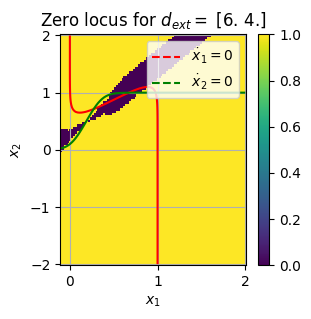

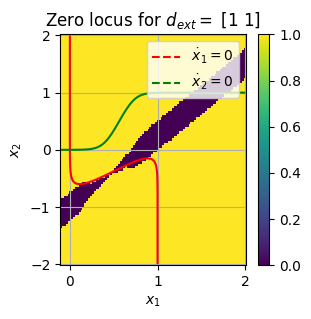

None


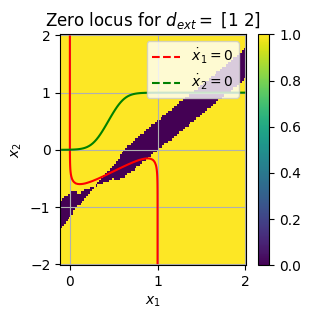

None


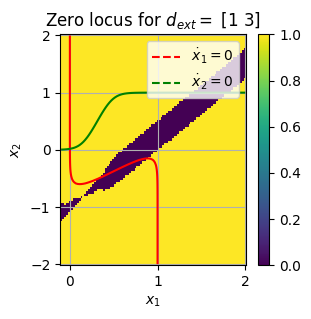

None


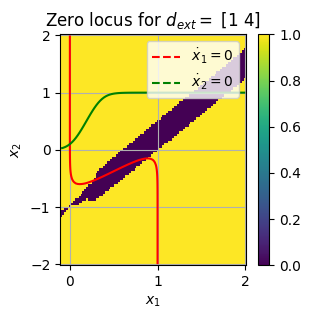

None


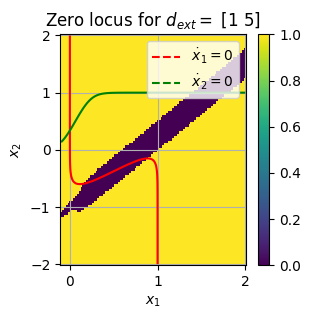

None


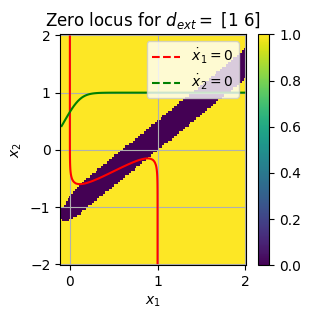

None


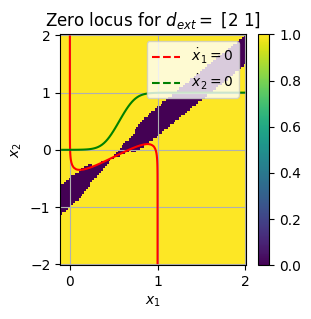

None


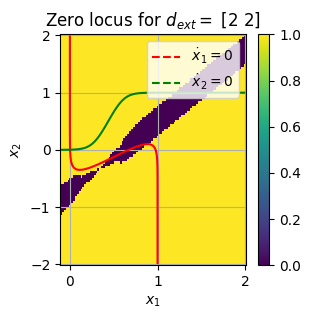

None


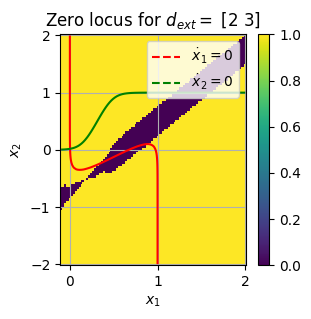

None


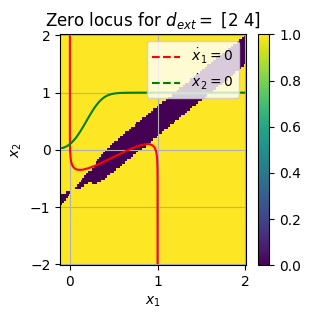

None


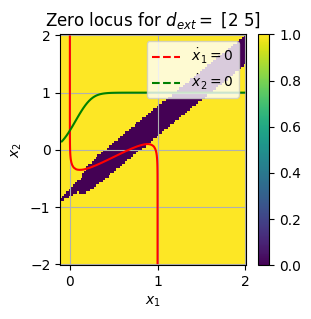

None


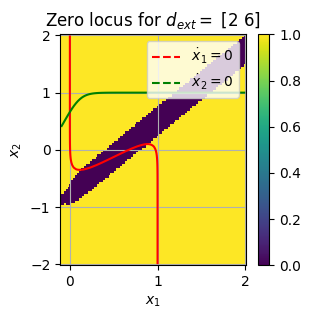

None


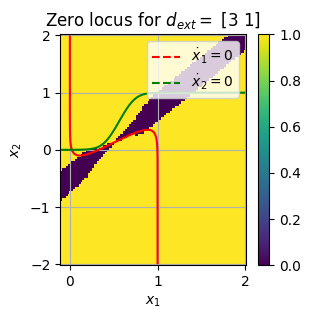

None


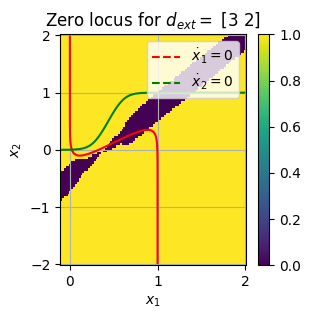

None


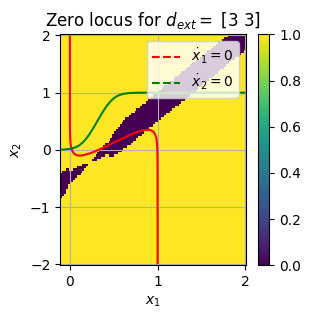

None


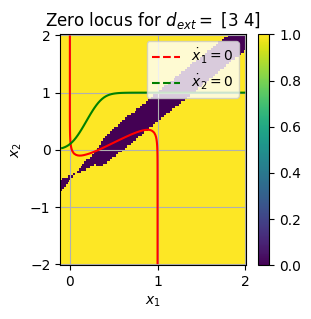

None


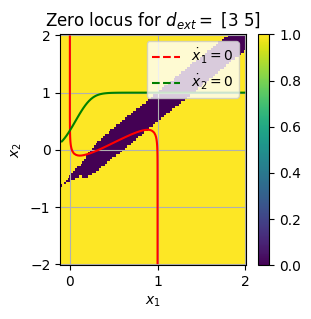

None


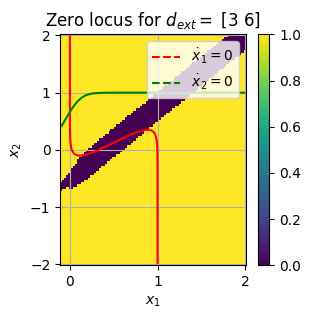

None


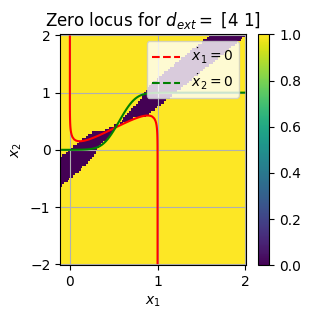

None


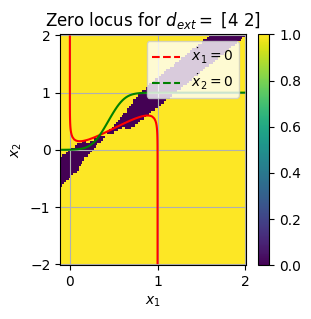

None


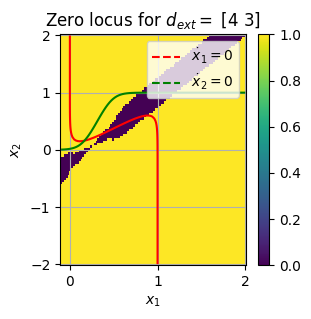

None


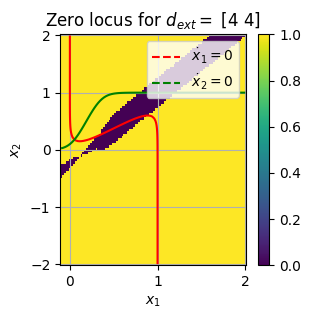

None


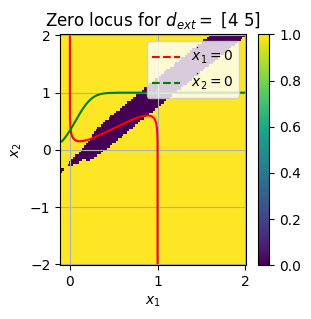

None


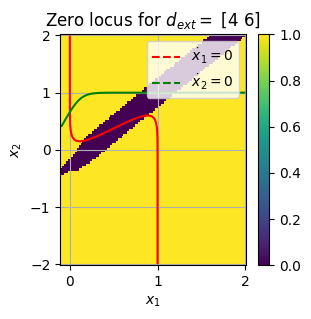

None


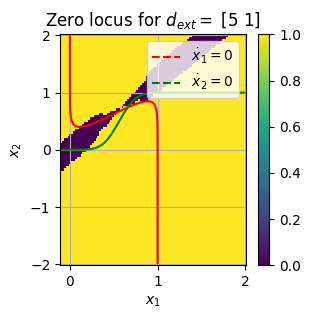

None


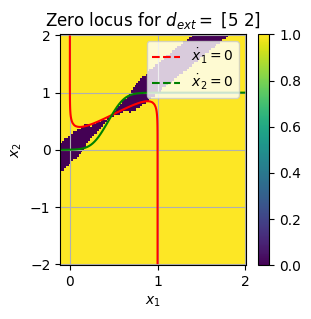

None


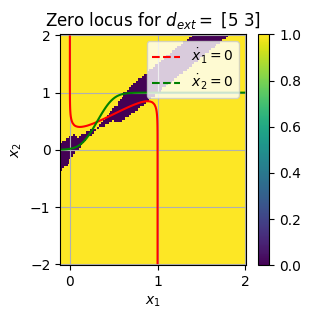

None


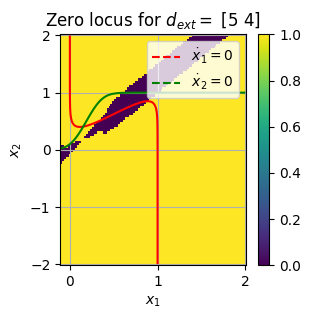

None


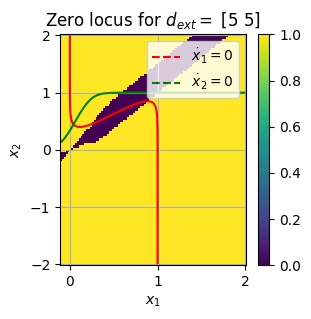

None


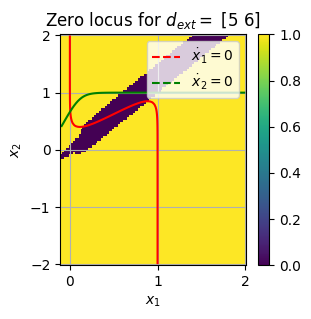

None


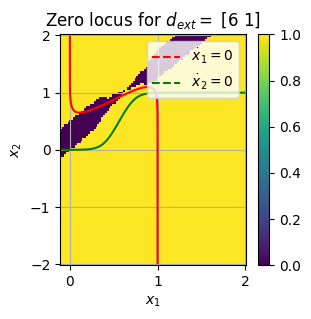

None


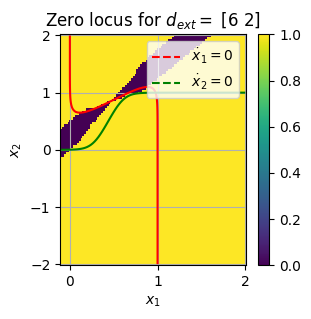

None


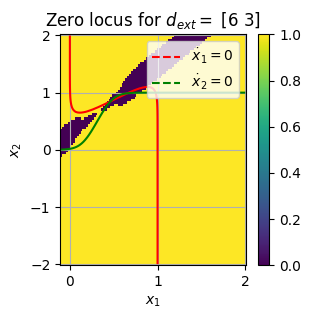

None


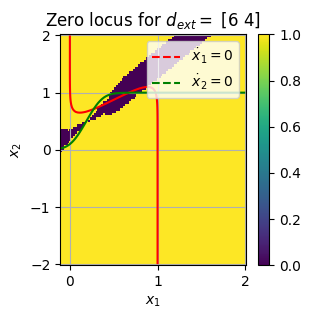

None


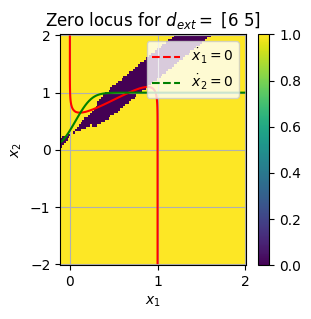

None


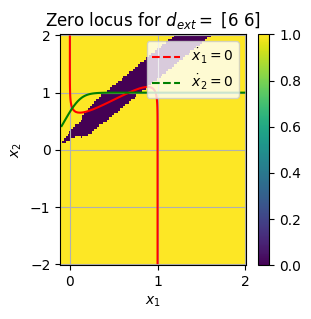

None


In [13]:
def part_exp(x1,x2,d_ext,i): #permet d'alléger le calcul de la jacobienne
    return np.exp(-a*(W[i,0]*x1+W[i,1]*x2+d_ext[i]-theta))

def jacobian_dynamics(x1,x2,d_ext):
    j11 = - 1 + 5*a*part_exp(x1,x2,d_ext,0)/(1+part_exp(x1,x2,d_ext,0))**2
    j12 = - 4*a*part_exp(x1,x2,d_ext,0)/(1+part_exp(x1,x2,d_ext,0))**2
    j21 = 8*a*part_exp(x1,x2,d_ext,1)/(1+part_exp(x1,x2,d_ext,1))**2
    j22 = - 1 - a*part_exp(x1,x2,d_ext,1)/(1+part_exp(x1,x2,d_ext,1))**2
    return np.array([[j11,j12],[j21,j22]]) # A COMPLETER

def plot_zero_locus_stabilite(d_ext):
    N = 100
    grid_x1 = np.linspace(-0.1,2.0,N)
    grid_x2 = np.linspace(-2.0,2.0,N)
    X1, X2 = np.meshgrid(grid_x1,grid_x2)

    X1dot = -X1 + sigmoid(W[0,0]*X1 + W[0,1]*X2 + d_ext[0])
    X2dot = -X2 + sigmoid(W[1,0]*X1 + W[1,1]*X2 + d_ext[1])

    # compute trace and determinant of jacobian matrix on the grid
    tr = np.zeros((N,N))
    deter = np.zeros((N,N))
    for i in np.arange(N):
        for j in np.arange(N):
            tr[i,j] = np.trace(jacobian_dynamics(X1[i,j],X2[i,j],d_ext))
            deter[i,j] = np.linalg.det(jacobian_dynamics(X1[i,j],X2[i,j],d_ext))

    # plot zone where  the trace of the jacobian is negative and its determinant positive
    plt.figure()
    plt.pcolormesh(X1,X2,(tr<0)*(deter>0))
    plt.colorbar() #permet de comprendre à quoi correspond chaque zone de couleur

    # root locus plot
    C1 = plt.contour(X1, X2, X1dot, 0, colors = 'red')
    C2 = plt.contour(X1, X2, X2dot, 0, colors = 'green')
    h1,_ = C1.legend_elements()
    h2,_ = C2.legend_elements()
    plt.grid(True)
    plt.xlabel('$x_1$')
    plt.ylabel('$x_2$')
    plt.legend([h1[0],h2[0]],['$\dot x_1 = 0$','$\dot x_2 = 0$'])
    plt.title("Zero locus for $d_{ext} =$ "+ str(d_ext))
    plt.show()

    return

plot_zero_locus_stabilite(np.array([6.0,4.0]))
for i in range(1,7):
    for j in range(1,7):
        print(plot_zero_locus_stabilite(np.array([i,j])))

**Réponse question 9**
 
Pour déterminer empiriquement la valeur de $d_{ext}$ pour laquelle on obtient un cycle limite, il faudrait faire évoluer le système de neurones pour une valeur de  $d_{ext}$ fixée et différentes conditions initiales. Si pour toutes les conditions initiales testées, le système admet la même unique position d'équilibre, instable, alors, d'après la question 8, on a un cycle limite. Si on peut utiliser une simulation, on peut regarder le portrait de phase pour cette valeur de  $d_{ext}$ et observer, comme on a fait en question 3, si on a une seul position d'équilibre, instable.

A l'aide de la simulation, on peut trouver une valeur de $d_{ext}$ qui permet d'obtenir un cycle limite.
On cherche les valeurs de $d_{ext}$ pour lesquelles il n'y a qu'une position d'équilibre, et pour lesquelles l'équilibre est instable (question 8).
Le déterminant étant le produit des valeurs propres (comptées avec multiplicité), et la trace étant leur somme, il suffit de chercher les valeurs de $d_{ext}$ pour lesquelles il n'y a qu'un croisement des courbes $\dot{x_1}=0$ et $\dot{x_2}=0$ (i.e. qu'une position d'équilibre), et dans lesquelles il est dans une zone bleue foncée (i.e. là où la Jacobienne est de Hurwitz : toutes ses valeurs propres sont à partie réelle strictement négative).
On trouve à l'aide des simulations les valeurs $(4,1)$, $(5,2)$.

Ainsi, des valeurs de $d_{ext}$ permettant d'observer un cycle limite sont $(4,1)$, $(5,2)$.